### Name: Swathi Subramanyam Pabbathi

### Date: 12/05/2025

### Implementation of object detection using DETR model

#### Importing all necessary libraries and installs

In [2]:
!pip install opencv-python
!pip install pycocotools
!pip install transformers==4.38.0

In [4]:
import torch
import cv2
import numpy as np
from pycocotools.coco import COCO
from transformers import DetrForObjectDetection, DetrImageProcessor

print("Torch:", torch.__version__)
print("NumPy:", np.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.6.0
NumPy: 2.2.6
CUDA available: True


### Load sample dataset 

In [5]:
import zipfile
import os

zip_path = "small_dataset.zip"   # ← update this if needed
extract_dir = "small_dataset"

# Remove existing folder if exists
if os.path.exists(extract_dir):
    import shutil
    shutil.rmtree(extract_dir)

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)

Dataset extracted to: small_dataset


In [6]:
yaml_text = """
train: small_dataset/train
val: small_dataset/valid
test: small_dataset/test

nc: 5
names:
  0: bicycle
  1: bus
  2: car
  3: license-plate
  4: motorcycle
"""

with open("small_dataset/data1.yaml", "w") as f:
    f.write(yaml_text)

print(" data1.yaml created successfully!")

 data1.yaml created successfully!


#### Train, Valid and Test splits and their counts

In [7]:
for split in ["train", "valid", "test"]:
    print(f"--- {split.upper()} ---")
    print("Images:", len(os.listdir(f"small_dataset/{split}/images")))
    print("Labels:", len(os.listdir(f"small_dataset/{split}/labels")))
    print()

--- TRAIN ---
Images: 9994
Labels: 9994

--- VALID ---
Images: 2141
Labels: 2141

--- TEST ---
Images: 2142
Labels: 2142



#### Sample visualizations from train,val and test splits

In [8]:
from IPython.display import display, Image
import cv2
import os
import random

def show_random_images(split_path, title, num_images=3):
    image_dir = os.path.join(split_path, "images")
    image_files = os.listdir(image_dir)
    selected = random.sample(image_files, num_images)

    print(f"=== {title} ===")
    for img_file in selected:
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Encode to JPEG for notebook display
        _, buffer = cv2.imencode(".jpg", img)
        display(Image(data=buffer))
        print(f"Image: {img_file}")

=== Train Sample ===


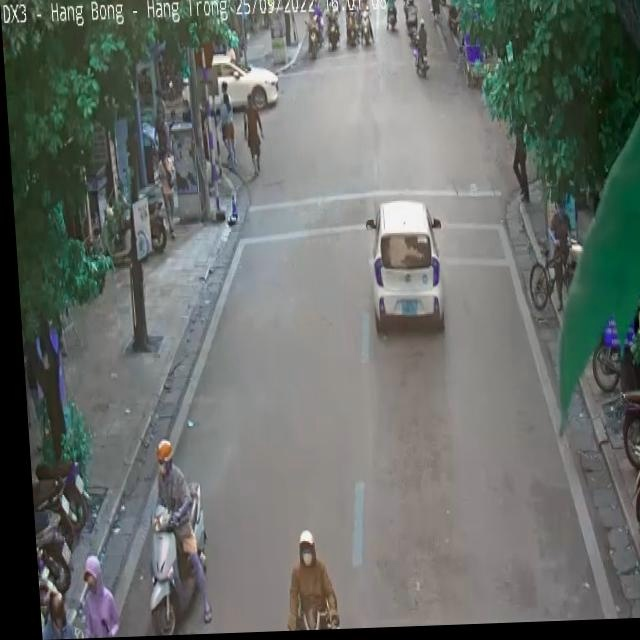

Image: Hang-Bong-Hang-Trong_16h-25-9-22_0035_jpg.rf.8edb6b12f45ad642c466d2315e732614.jpg


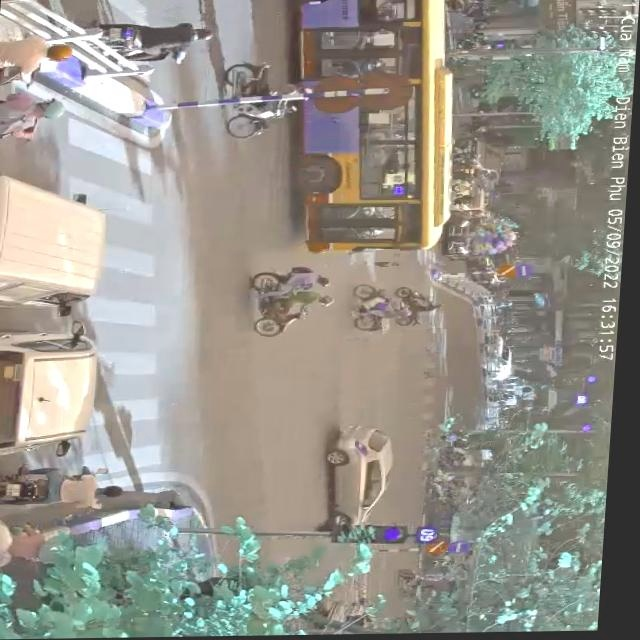

Image: Cua-Nam-Dien-Bien-Phu_16h30-5-9-22_0061_jpg.rf.8fd926c6caea7ff917b10aea3cfa3d22.jpg


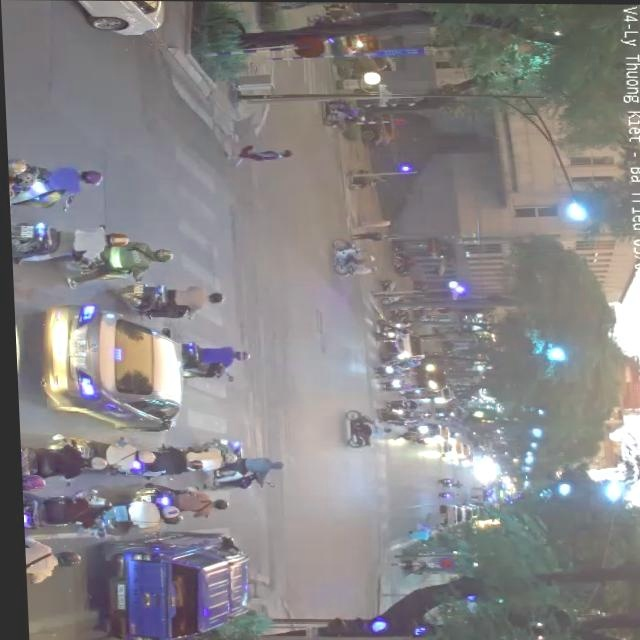

Image: Ly-Thuong-Kiet-Ba-Trieu_16h-15-9-22_0046_jpg.rf.0988d3409ddc5a083f8e90d9571d38f8.jpg
=== Valid Sample ===


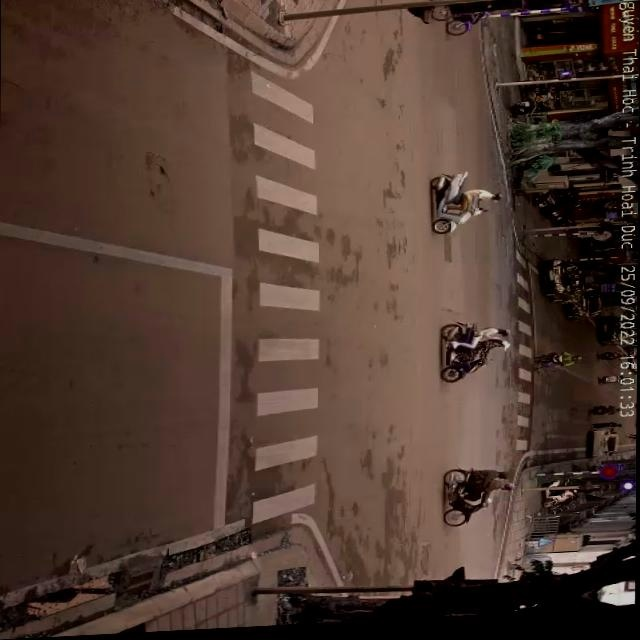

Image: Nguyen-Thai-Hoc-Trinh-Hoai-Duc_16h-25-9-22_0039_jpg.rf.dc9ad0e96d6fab6ec59492fe08f929f0.jpg


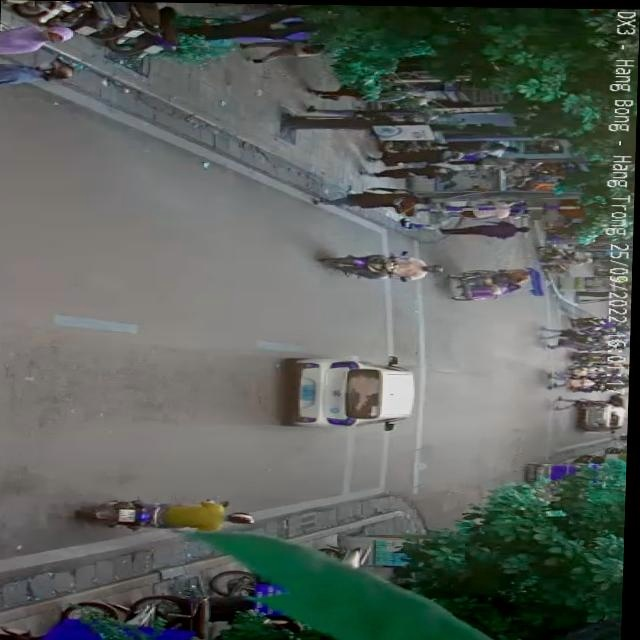

Image: Hang-Bong-Hang-Trong_16h-25-9-22_0044_jpg.rf.3341793c8537d2a62b4c1f500d006630.jpg


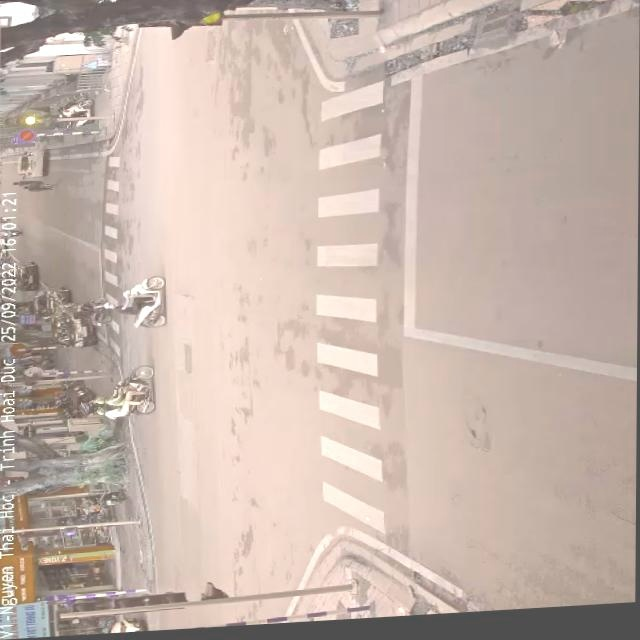

Image: Nguyen-Thai-Hoc-Trinh-Hoai-Duc_16h-25-9-22_0027_jpg.rf.7a33f77a2dab939c6a423f48f09b928d.jpg
=== Test Sample ===


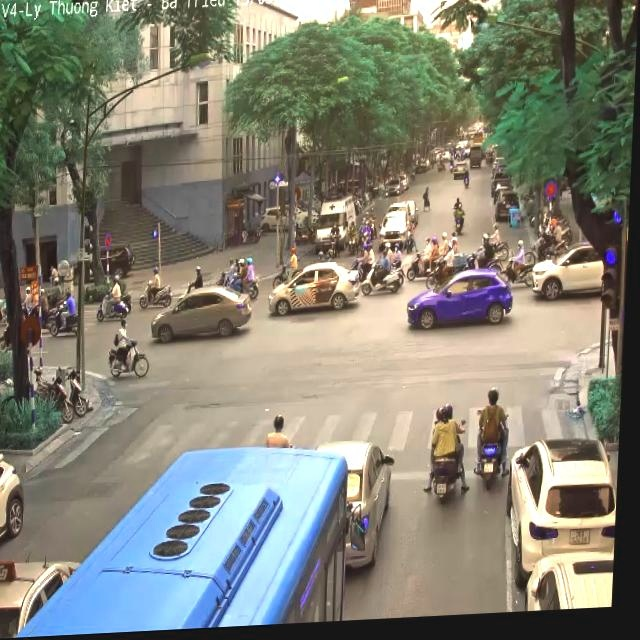

Image: Ly-Thuong-Kiet-Ba-Trieu_16h15-15-9-22_0018_jpg.rf.3e8a03c600ff7b618a464845207ebc36.jpg


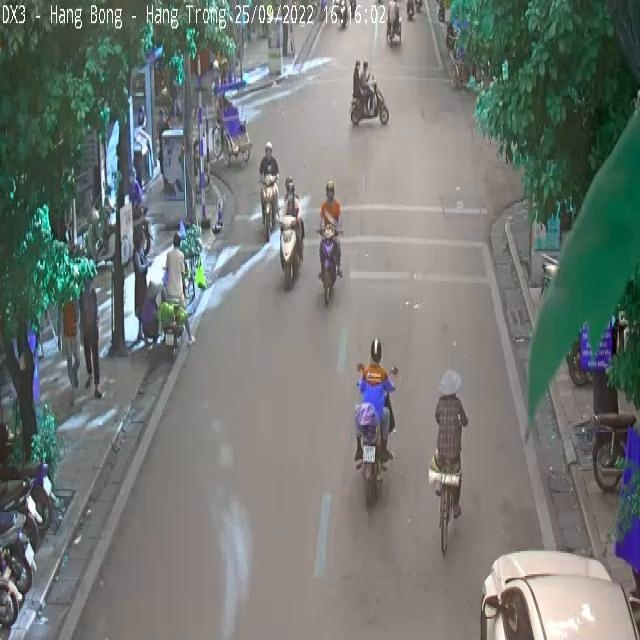

Image: Hang-Bong-Hang-Trong_16h15-25-9-22_0033_jpg.rf.78445031bc9451bb2601fa4f53cfe5a9.jpg


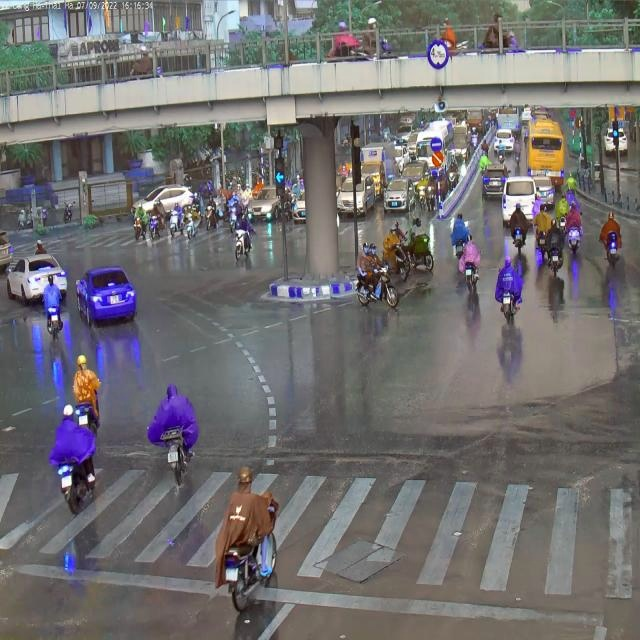

Image: Lang-Ha-Thai-Ha-1-_16h15-7-9-22_0055_jpg.rf.bc01bbaeaa5b909dc9cba26aa094352a.jpg


In [9]:
train_path = "small_dataset/train"
valid_path = "small_dataset/valid"
test_path  = "small_dataset/test"

show_random_images(train_path, "Train Sample")
show_random_images(valid_path, "Valid Sample")
show_random_images(test_path, "Test Sample")

### Image Preprocessing
#### Data Cleaning - Remove corrupted or unreadable images

In [10]:
# Remove Corrupted Images
def find_bad_images(path):
    bad = []
    for f in os.listdir(path):
        img = cv2.imread(os.path.join(path, f))
        if img is None:
            bad.append(f)
    return bad

bad_train = find_bad_images("small_dataset/train/images")
bad_valid = find_bad_images("small_dataset/valid/images")
bad_test  = find_bad_images("small_dataset/test/images")

bad_train, bad_valid, bad_test

([], [], [])

#### Consider a sample subset of train,test and valid datasets

In [11]:
import shutil
# -----------------------------
# Paths to your existing dataset
# -----------------------------
original_paths = {
    "train": "small_dataset/train",
    "valid": "small_dataset/valid",
    "test": "small_dataset/test"
}

# -----------------------------
# Collect all images into one list
# -----------------------------
all_images = []

for split in original_paths:
    imgs = os.listdir(os.path.join(original_paths[split], "images"))
    imgs = [os.path.join(original_paths[split], "images", f) for f in imgs]
    all_images.extend(imgs)

print("Total images found:", len(all_images))

# -----------------------------
# Sample size (train max = 200)
# -----------------------------
train_size = 1000
total = train_size / 0.70   # train is 70%

valid_size = int(total * 0.15)
test_size = int(total * 0.15)

print("Sampling:")
print("Train:", train_size)
print("Valid:", valid_size)
print("Test :", test_size)

# -----------------------------
# Random sampling
# -----------------------------
random.shuffle(all_images)

train_images = all_images[:train_size]
valid_images = all_images[train_size : train_size + valid_size]
test_images  = all_images[train_size + valid_size : train_size + valid_size + test_size]

# -----------------------------
# Create new dataset folders
# -----------------------------
base = "smaller_dataset"

for split in ["train", "valid", "test"]:
    os.makedirs(f"{base}/{split}/images", exist_ok=True)
    os.makedirs(f"{base}/{split}/labels", exist_ok=True)

def copy_with_label(img_path, out_split):
    img_name = os.path.basename(img_path)
    lbl_name = img_name.replace(".jpg", ".txt").replace(".png", ".txt")

    # Copy image
    shutil.copy(img_path, f"{base}/{out_split}/images/{img_name}")

    # Copy label from corresponding original folder
    for split in original_paths:
        lbl_path = os.path.join(original_paths[split], "labels", lbl_name)
        if os.path.exists(lbl_path):
            shutil.copy(lbl_path, f"{base}/{out_split}/labels/{lbl_name}")
            return True
    return False

# -----------------------------
# Copy images + labels
# -----------------------------
for img in train_images:
    copy_with_label(img, "train")

for img in valid_images:
    copy_with_label(img, "valid")

for img in test_images:
    copy_with_label(img, "test")

print("\n DONE! Smaller dataset created at: smaller_dataset")

Total images found: 14277
Sampling:
Train: 1000
Valid: 214
Test : 214

 DONE! Smaller dataset created at: smaller_dataset


In [12]:
yaml_text = """
train: smaller_dataset/train/images
val: smaller_dataset/valid/images
test: smaller_dataset/test/images

nc: 5
names:
  0: bicycle
  1: bus
  2: car
  3: license-plate
  4: motorcycle
"""

with open("data2.yaml", "w") as f:
    f.write(yaml_text)

print(" data2.yaml created successfully!")

 data2.yaml created successfully!


#### Show Invalid/missing Labels, Display Image, and Delete Files

In [13]:
def check_label_file(path):
    """Returns False if label file contains invalid YOLO bounding boxes."""
    try:
        with open(path) as f:
            lines = f.read().strip().split("\n")

        for l in lines:
            parts = l.split()
            if len(parts) != 5:
                return False

            cls, x, y, w, h = map(float, parts)
            if not (0 <= x <= 1 and 0 <= y <= 1 and w > 0 and h > 0):
                return False

    except:
        return False

    return True


# --------------------------------------------------------------
# Function to clean a dataset split (train, valid, test)
# --------------------------------------------------------------
def clean_split(split_path):
    label_dir = f"{split_path}/labels"
    image_dir = f"{split_path}/images"

    invalid = []

    print(f"\n Checking labels in: {split_path}")

    # Find invalid labels
    for f in os.listdir(label_dir):
        lbl_path = os.path.join(label_dir, f)
        if not check_label_file(lbl_path):
            invalid.append(f)

    print(" Invalid label files:", invalid)

    # Display and delete invalid images + labels
    for lbl_file in invalid:
        # Match image name (.jpg or .png)
        img_base = lbl_file.replace(".txt", "")
        img_jpg = os.path.join(image_dir, img_base + ".jpg")
        img_png = os.path.join(image_dir, img_base + ".png")

        img_path = img_jpg if os.path.exists(img_jpg) else img_png
        lbl_path = os.path.join(label_dir, lbl_file)

        # Display image if present
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.title(f"Deleting: {os.path.basename(img_path)}")
            plt.axis("off")
            plt.show()

        # Delete image
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f" Deleted image: {img_path}")

        # Delete label
        if os.path.exists(lbl_path):
            os.remove(lbl_path)
            print(f" Deleted label: {lbl_path}")

    print(" Cleanup complete for:", split_path)


# --------------------------------------------------------------
# Run cleaning for all dataset splits
# --------------------------------------------------------------

base = "smaller_dataset"

for split in ["train", "valid", "test"]:
    clean_split(f"{base}/{split}")


 Checking labels in: smaller_dataset/train
 Invalid label files: []
 Cleanup complete for: smaller_dataset/train

 Checking labels in: smaller_dataset/valid
 Invalid label files: []
 Cleanup complete for: smaller_dataset/valid

 Checking labels in: smaller_dataset/test
 Invalid label files: []
 Cleanup complete for: smaller_dataset/test


#### Finding Class Imbalance

In [14]:
import os
from collections import Counter

counter = Counter()

for split in ["train", "valid", "test"]:
    label_dir = f"smaller_dataset/{split}/labels"
    for f in os.listdir(label_dir):
        with open(f"{label_dir}/{f}") as lbl:
            for line in lbl:
                cls = int(line.split()[0])
                counter[cls] += 1

counter

Counter({4: 32147, 2: 10317, 1: 589, 0: 327, 3: 147})

In [15]:
import shutil

# Folder you want to zip
folder_path = "smaller_dataset"
output_zip = "smaller_dataset.zip"   # name of zip file

# Create zip archive
shutil.make_archive(output_zip.replace(".zip", ""), 'zip', folder_path)

print(" Zip file created:", output_zip)

 Zip file created: smaller_dataset.zip


In [16]:
import os
import json
import cv2

# Base path
BASE_PATH = "smaller_dataset"

CLASS_NAMES = [
    "bicycle",
    "bus",
    "car",
    "license-plate",
    "motorcycle"
]

def yolo_to_coco(split="train"):
    print(f"\nConverting {split} to COCO format...")

    images_dir = os.path.join(BASE_PATH, split, "images")
    labels_dir = os.path.join(BASE_PATH, split, "labels")
    output_file = os.path.join(BASE_PATH, f"{split}_coco.json")

    coco = {
    "info": {
        "description": "Small vehicle dataset",
        "version": "1.0",
        "year": 2025,
        "contributor": "Swathi",
        "date_created": "2025-01-01"
    },
    "licenses": [
        {
            "id": 1,
            "name": "Unknown",
            "url": ""
        }
    ],
    "images": [],
    "categories": [],
    "annotations": []
    }

    # categories
    for idx, name in enumerate(CLASS_NAMES):
        coco["categories"].append({
            "id": idx,
            "name": name
        })

    annotation_id = 1
    image_id = 1

    for filename in os.listdir(images_dir):
        if not filename.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        img_path = os.path.join(images_dir, filename)
        label_path = os.path.join(labels_dir, filename.rsplit(".",1)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w = img.shape[:2]

        coco["images"].append({
            "id": image_id,
            "file_name": filename,
            "width": w,
            "height": h
        })

        with open(label_path) as f:
            lines = f.readlines()

        for line in lines:
            values = line.strip().split()
            if len(values) != 5:
                continue

            cls, xc, yc, bw, bh = values
            cls = int(cls)
            xc, yc, bw, bh = map(float, (xc, yc, bw, bh))

            # Normalize --> absolute
            x_center = xc * w
            y_center = yc * h
            width = bw * w
            height = bh * h

            x_min = x_center - (width / 2)
            y_min = y_center - (height / 2)

            if width <= 0 or height <= 0:
                continue

            coco["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": cls,
                "bbox": [
                    round(x_min, 2),
                    round(y_min, 2),
                    round(width, 2),
                    round(height, 2)
                ],
                "area": round(width * height, 2),
                "iscrowd": 0
            })

            annotation_id += 1

        image_id += 1

    with open(output_file, "w") as f:
        json.dump(coco, f, indent=4)

    print(f" COCO file generated -> {output_file}")
    print(f"Images: {len(coco['images'])}, Annotations: {len(coco['annotations'])}")


# Run for all splits
for split in ["train", "valid", "test"]:
    yolo_to_coco(split)


Converting train to COCO format...
 COCO file generated -> smaller_dataset/train_coco.json
Images: 1936, Annotations: 30304

Converting valid to COCO format...
 COCO file generated -> smaller_dataset/valid_coco.json
Images: 425, Annotations: 6746

Converting test to COCO format...
 COCO file generated -> smaller_dataset/test_coco.json
Images: 425, Annotations: 6477


In [17]:
pip install pycocotools matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.


#### Now lets visualize with annotations provided

In [18]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

BASE_PATH = "smaller_dataset"

def show_coco_images(split, n=3):
    print(f"\nShowing {n} images from {split.upper()} set")

    ann_file = os.path.join(BASE_PATH, f"{split}_coco.json")
    img_dir  = os.path.join(BASE_PATH, split, "images")

    print("Annotation file:", ann_file)
    print("Image folder:", img_dir)

    coco = COCO(ann_file)
    image_ids = coco.getImgIds()

    if len(image_ids) < n:
        print(f" Only {len(image_ids)} images found in {split}")
        selected_ids = image_ids
    else:
        selected_ids = random.sample(image_ids, n)

    for img_id in selected_ids:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]

        # Only use the filename (ignore any folder stored in JSON)
        img_path = os.path.join(img_dir, os.path.basename(file_name))
        print("Trying:", img_path)

        if not os.path.exists(img_path):
            print(" FILE NOT FOUND:", img_path)
            continue

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = coco.getAnnIds(imgIds=[img_id])
        anns = coco.loadAnns(ann_ids)

        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis("off")

        for ann in anns:
            x, y, w, h = ann["bbox"]

            # Draw bounding box
            rect = plt.Rectangle(
                (x, y), w, h,
                fill=False,
                edgecolor='red',
                linewidth=2
            )
            plt.gca().add_patch(rect)

            # Category name
            cat = coco.loadCats([ann["category_id"]])[0]["name"]

            plt.text(
                x, y - 5,
                cat,
                color="yellow",
                fontsize=10,
                backgroundcolor="black"
            )

        plt.show()


Showing 3 images from TRAIN set
Annotation file: smaller_dataset/train_coco.json
Image folder: smaller_dataset/train/images
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Trying: smaller_dataset/train/images/Giang-Vo-Lang-Ha_16h-25-9-22_0024_jpg.rf.188ad34d90683f084b1842bc64a5dc22.jpg


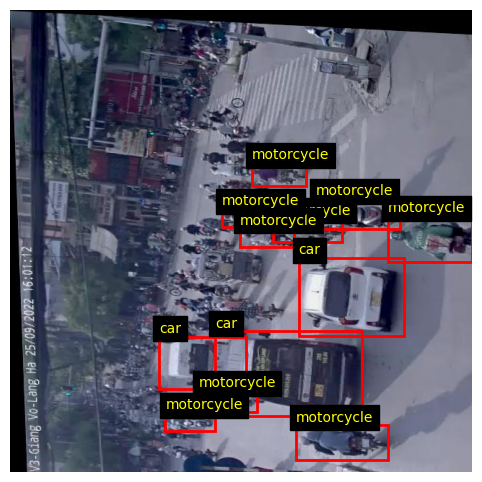

Trying: smaller_dataset/train/images/Le-Duan-Nguyen-Thai-Hoc_16h30-25-9-22_0002_jpg.rf.913d4c0a41cc762dfa944e3dd01e2c74.jpg


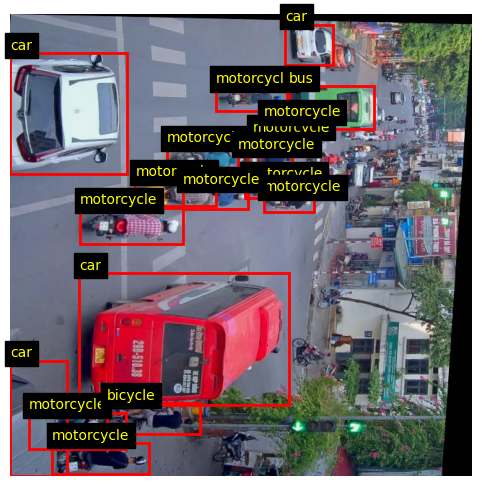

Trying: smaller_dataset/train/images/Nguyen-Thai-Hoc-Ton-Duc-Thang_16h15-15-9-22_0053_jpg.rf.873337fb17c3e578366f7ab879cfef64.jpg


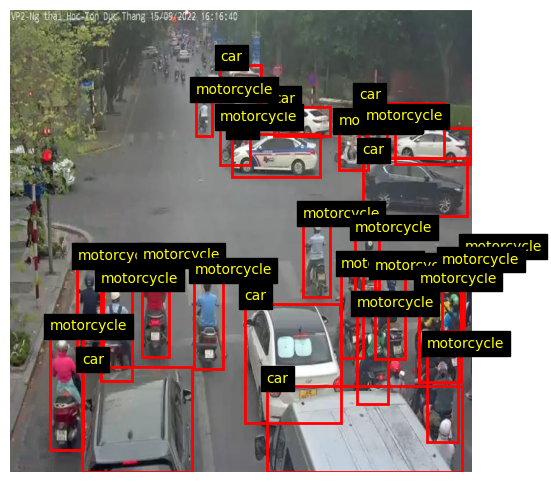


Showing 3 images from VALID set
Annotation file: smaller_dataset/valid_coco.json
Image folder: smaller_dataset/valid/images
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Trying: smaller_dataset/valid/images/Hang-Bong-Hang-Trong_16h30-7-9-22_0033_jpg.rf.618910a7cee2b9e44084f4a81ee161ba.jpg


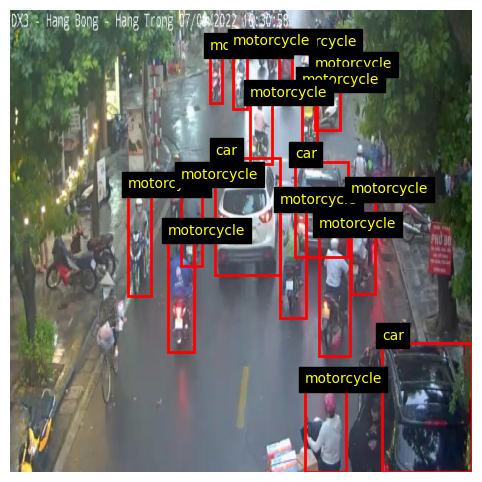

Trying: smaller_dataset/valid/images/Ly-Thuong-Kiet-Hang-Bai_16h-15-9-22_0024_jpg.rf.5b7b6b49e1bec947b67c28836837f351.jpg


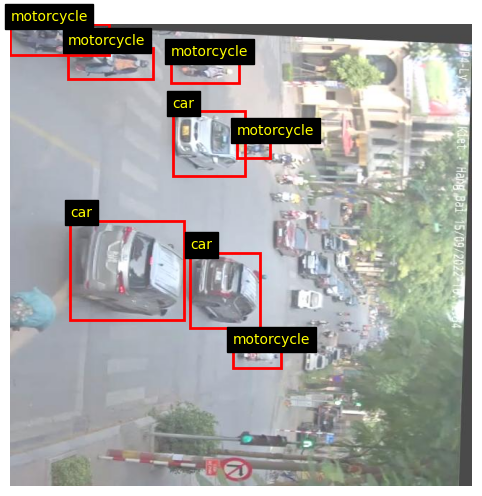

Trying: smaller_dataset/valid/images/Hang-Bong-Hang-Trong_16h-30-25-9-22_0032_jpg.rf.b57cc0859d82000cd1d60d0134dbb227.jpg


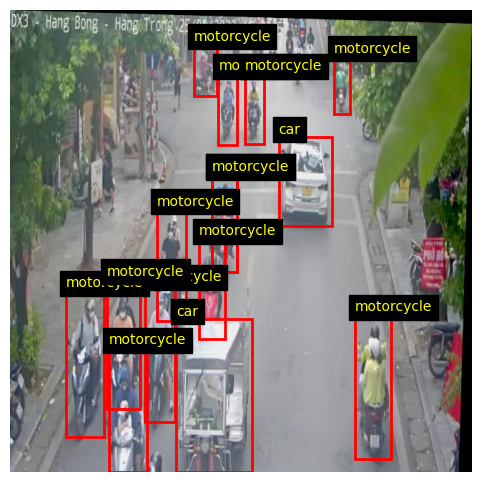


Showing 3 images from TEST set
Annotation file: smaller_dataset/test_coco.json
Image folder: smaller_dataset/test/images
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Trying: smaller_dataset/test/images/Hang-Bong-Hang-Trong_16h30-7-9-22_0036_jpg.rf.1231ba2b3ff6f7e07001858bfaddea48.jpg


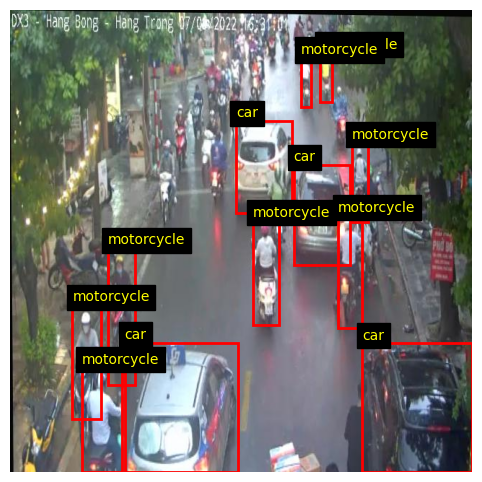

Trying: smaller_dataset/test/images/Ly-Thuong-Kiet-Ba-Trieu_16h-25-9-22_0042_jpg.rf.ea93435619cefe8c8e1ccdd5eca632c6.jpg


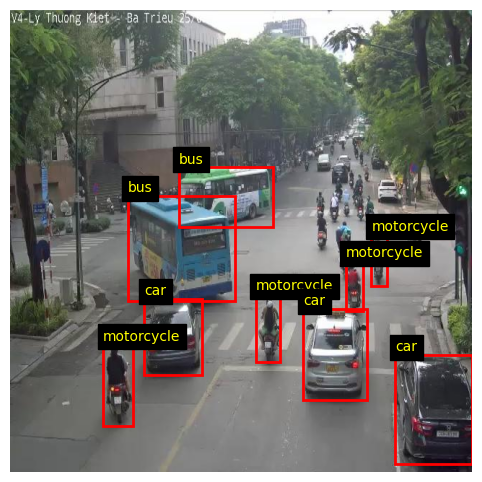

Trying: smaller_dataset/test/images/Nguyen-Thai-Hoc-Ton-Duc-Thang_16h15-25-9-22_0038_jpg.rf.5774778b9d0a660d6f0e2d2b30232253.jpg


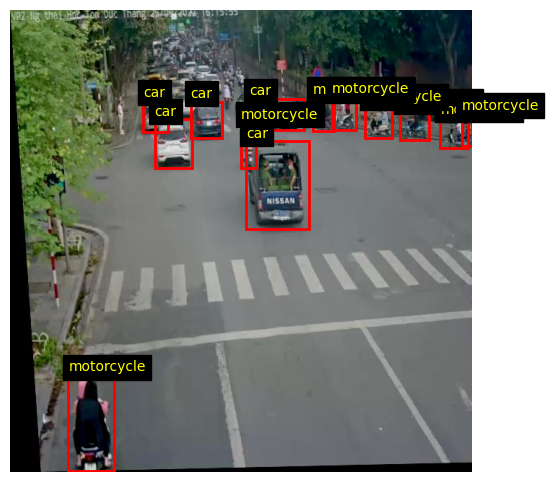

In [20]:
show_coco_images("train", 3)
show_coco_images("valid", 3)
show_coco_images("test", 3)

###$ check for class imbalances


 Class distribution in TRAIN set:

motorcycle           : 22375
car                  : 7173
bus                  : 415
bicycle              : 232
license-plate        : 109


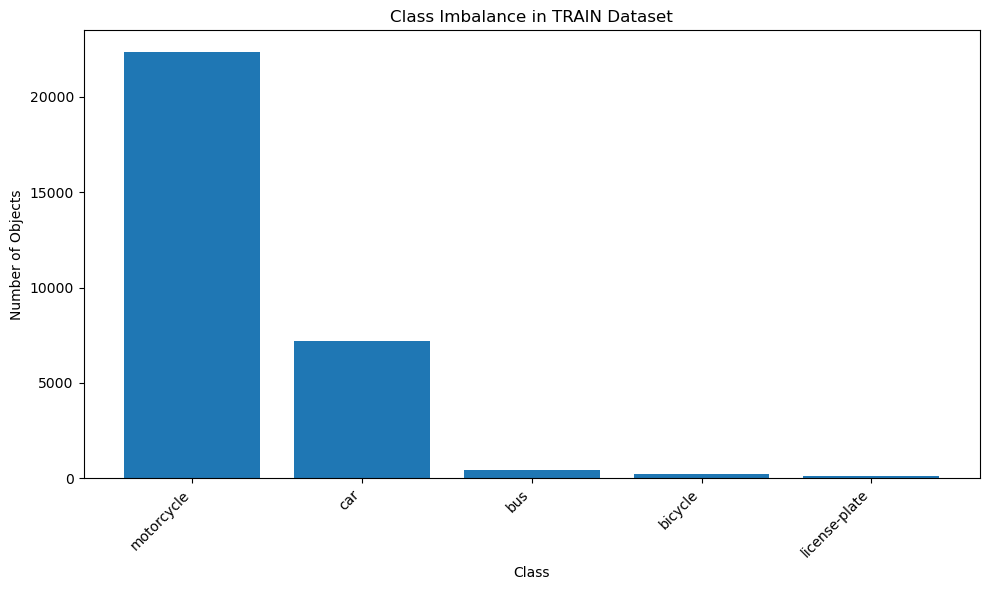

In [19]:
import json
from collections import Counter
import matplotlib.pyplot as plt

train_json = "smaller_dataset/train_coco.json"

# Load COCO file
with open(train_json, "r") as f:
    coco = json.load(f)

# Build category id -> name mapping
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Count instances per category
class_counts = Counter()

for ann in coco["annotations"]:
    cat_id = ann["category_id"]
    class_counts[categories[cat_id]] += 1

# Sort for better readability
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

print("\n Class distribution in TRAIN set:\n")
for cls, count in class_counts.items():
    print(f"{cls:20} : {count}")

# Plot class imbalance
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha="right")
plt.title("Class Imbalance in TRAIN Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Objects")
plt.tight_layout()
plt.show()

In [ ]:
# Oversampling the minority classes to balance th dataset
import json
import copy

# Input / Output paths
INPUT_JSON  = "smaller_dataset/train_coco.json"
OUTPUT_JSON = "smaller_dataset/train_coco_balanced.json"

BICYCLE_MULTIPLIER = 15
BUS_MULTIPLIER = 10

with open(INPUT_JSON, "r") as f:
    coco = json.load(f)

# Build category id → name
categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

# Separate original annotations
original_anns = coco["annotations"]

# Find max annotation id (for new ids)
max_id = max([ann["id"] for ann in original_anns])

new_annotations = []
current_id = max_id + 1

for ann in original_anns:

    # Copy original annotation
    new_annotations.append(ann)

    class_name = categories[ann["category_id"]]

    # Oversample bicycle
    if class_name == "bicycle":
        for _ in range(BICYCLE_MULTIPLIER - 1):
            duplicate = copy.deepcopy(ann)
            duplicate["id"] = current_id
            current_id += 1
            new_annotations.append(duplicate)

    # Oversample bus
    elif class_name == "bus":
        for _ in range(BUS_MULTIPLIER - 1):
            duplicate = copy.deepcopy(ann)
            duplicate["id"] = current_id
            current_id += 1
            new_annotations.append(duplicate)

# Replace annotations
coco["annotations"] = new_annotations

# Save balanced file
with open(OUTPUT_JSON, "w") as f:
    json.dump(coco, f)

print(" Balancing complete!")
print("Saved as:", OUTPUT_JSON)
print("Original annotations:", len(original_anns))
print("New annotations:", len(new_annotations))

 Balancing complete!
Saved as: smaller_dataset/train_coco_balanced.json
Original annotations: 30304
New annotations: 37287


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Random image: smaller_dataset/train/images/Nguyen-Thai-Hoc-Trinh-Hoai-Duc_16h-30-15-9-22_0010_jpg.rf.db1da5a8e09a96505483b411193289e8.jpg


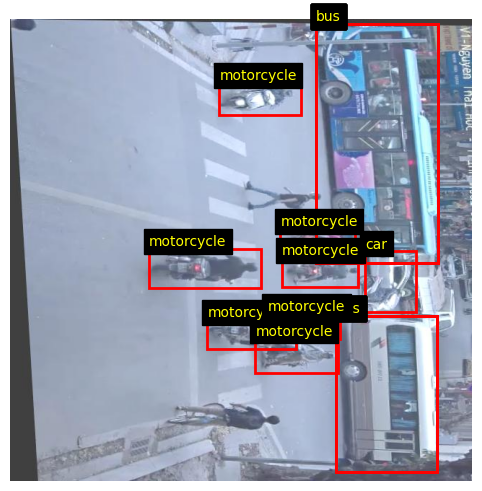

In [21]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

BASE_PATH = "smaller_dataset"

# Paths
ann_file = os.path.join(BASE_PATH, "train_coco_balanced.json")
img_dir  = os.path.join(BASE_PATH, "train", "images")

# Load COCO
coco = COCO(ann_file)

# Pick random image id
img_id = random.choice(coco.getImgIds())
img_info = coco.loadImgs(img_id)[0]
file_name = img_info["file_name"]

# Make sure we use only filename (ignore any path in JSON)
img_path = os.path.join(img_dir, os.path.basename(file_name))

print("Random image:", img_path)

# Read image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get annotations
ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)

# Plot
plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis("off")

for ann in anns:
    x, y, w, h = ann["bbox"]

    # draw box
    rect = plt.Rectangle(
        (x, y), w, h,
        fill=False,
        edgecolor="red",
        linewidth=2
    )
    plt.gca().add_patch(rect)

    # category name
    cat = coco.loadCats([ann["category_id"]])[0]["name"]

    plt.text(
        x, y-5,
        cat,
        color="yellow",
        fontsize=10,
        backgroundcolor="black"
    )

plt.show()

#### Model Training

In [ ]:
!pip install transformers==4.38.0 datasets pycocotools accelerate

In [24]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DetrForObjectDetection, DetrImageProcessor
from pycocotools.coco import COCO
import cv2
import numpy as np

In [73]:
# # Updated COCO to DETR Dataset Class
class CocoDetectionDataset(Dataset):
    def __init__(self, img_folder, ann_file, processor):
        self.img_folder = img_folder
        self.coco = COCO(ann_file)
        self.processor = processor
        self.image_ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        # ---------------------
        # Load Image
        # ---------------------
        img_info = self.coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]
        img_path = os.path.join(self.img_folder, file_name)

        image = cv2.imread(img_path)
        if image is None:
            # Skip unreadable images
            return self.__getitem__((idx + 1) % len(self))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ---------------------
        # Load annotations
        # ---------------------
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Skip images with no annotations
        if len(anns) == 0:
            return self.__getitem__((idx + 1) % len(self))

        # ---------------------
        # Prepare target for DETR
        # ---------------------
        target = {"image_id": torch.tensor([img_id]), "annotations": []}

        for ann in anns:
            x, y, w, h = ann["bbox"]

            # Skip invalid boxes
            if w <= 0 or h <= 0:
                continue

            target["annotations"].append({
                "bbox": [x, y, w, h],
                "category_id": ann["category_id"],
                "area": ann.get("area", w * h),
                "iscrowd": ann.get("iscrowd", 0)
            })

        # If after filtering no boxes left, skip image
        if len(target["annotations"]) == 0:
            return self.__getitem__((idx + 1) % len(self))

        # ---------------------
        # Process with DETR Processor
        # ---------------------
        encoding = self.processor(
            images=image,
            annotations=target,
            return_tensors="pt"
        )
        print("\n--- Debug Normalization Check ---")
        print("Original bbox (absolute xywh):", target["annotations"][0]["bbox"])
        print("Normalized DETR bbox (cxcywh):", encoding["labels"][0]["boxes"][0])
        print("---------------------------------\n")

        # Some outputs from processor come inside lists → flatten properly
        out = {}
        for k, v in encoding.items():
            if isinstance(v, list):
                # list of dicts (labels)
                out[k] = v[0]
            else:
                # tensor
                out[k] = v.squeeze(0)
        return out

In [27]:
# Initialize Processor
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [28]:
# Create Dataset Instances
BASE = "smaller_dataset"

train_dataset = CocoDetectionDataset(
    img_folder=f"{BASE}/train/images",
    ann_file=f"{BASE}/train_coco_balanced.json",
    processor=processor
)

val_dataset = CocoDetectionDataset(
    img_folder=f"{BASE}/valid/images",
    ann_file=f"{BASE}/valid_coco.json",
    processor=processor
)

test_dataset = CocoDetectionDataset(
    img_folder=f"{BASE}/test/images",
    ann_file=f"{BASE}/test_coco.json",
    processor=processor
)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [29]:
# DataLoaders
from torch.utils.data import DataLoader

def collate_fn(batch):
    return batch

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [31]:
# Load DETR Model With 5 Classes
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=5,                  # bicycle, bus, car, license-plate, motorcycle
    ignore_mismatched_sizes=True   # required for classifier reshape
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [33]:
# Training Loop
from tqdm import tqdm

def train_one_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader):
        pixel_values = torch.stack([b["pixel_values"] for b in batch]).to(device)
        pixel_mask   = torch.stack([b["pixel_mask"] for b in batch]).to(device)
        labels = [{k: v.to(device) for k, v in b["labels"].items()} for b in batch]

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [34]:
# Validation Loop
def validate(model, data_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            pixel_values = torch.stack([b["pixel_values"] for b in batch]).to(device)
            pixel_mask   = torch.stack([b["pixel_mask"] for b in batch]).to(device)
            labels = [{k: v.to(device) for k, v in b["labels"].items()} for b in batch]

            outputs = model(
                pixel_values=pixel_values,
                pixel_mask=pixel_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

    return total_loss / len(data_loader)

In [35]:
train_losses = []
val_losses = []

EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")

# save loss curves for later use
import json
json.dump({"train": train_losses, "val": val_losses}, open("loss_history.json", "w"))

100%|██████████| 968/968 [03:30<00:00,  4.60it/s]


Epoch 1: Train=2.7820, Val=2.0482


100%|██████████| 968/968 [03:28<00:00,  4.64it/s]


Epoch 2: Train=2.3733, Val=1.5057


100%|██████████| 968/968 [03:29<00:00,  4.62it/s]


Epoch 3: Train=2.0338, Val=1.3871


100%|██████████| 968/968 [03:28<00:00,  4.65it/s]


Epoch 4: Train=1.8774, Val=1.3020


100%|██████████| 968/968 [03:27<00:00,  4.66it/s]


Epoch 5: Train=1.8059, Val=1.4405


100%|██████████| 968/968 [03:25<00:00,  4.70it/s]


Epoch 6: Train=1.6506, Val=1.1625


100%|██████████| 968/968 [03:29<00:00,  4.62it/s]


Epoch 7: Train=1.7671, Val=1.3062


100%|██████████| 968/968 [03:26<00:00,  4.68it/s]


Epoch 8: Train=1.6734, Val=1.2708


100%|██████████| 968/968 [03:27<00:00,  4.67it/s]


Epoch 9: Train=1.7874, Val=1.5595


100%|██████████| 968/968 [03:27<00:00,  4.67it/s]


Epoch 10: Train=1.7255, Val=1.2347


#### Training and validation loss curves visualizations

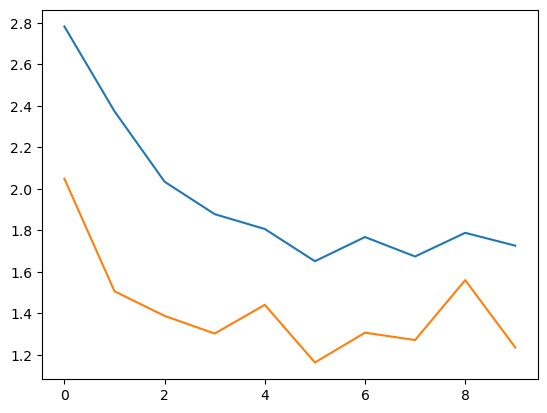

In [36]:
losses = json.load(open("loss_history.json"))
plt.plot(losses["train"])
plt.plot(losses["val"])

In [37]:
save_dir = "detr_vehicle_model"

model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print("Model + processor saved →", save_dir)

Model + processor saved → detr_vehicle_model


#### Saved the trained model

In [39]:
torch.save(model.state_dict(), "detr_vehicle_model.pt")

In [40]:
from transformers import DetrForObjectDetection, DetrImageProcessor

model = DetrForObjectDetection.from_pretrained("detr_vehicle_model")
processor = DetrImageProcessor.from_pretrained("detr_vehicle_model")

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# VERY IMPORTANT — MOVE TIMM BACKBONE SUBMODULES TO GPU
for name, module in model.named_modules():
    if "backbone" in name or "conv_encoder" in name:
        module.to(device)

#### Model Evaluation

In [42]:
# Function to Run DETR Inference on test dataset
import numpy as np
from tqdm import tqdm

def evaluate_detr(model, data_loader, processor, coco_gt):
    model.eval()
    coco_results = []

    for batch in tqdm(data_loader):
        pixel_values = torch.stack([b["pixel_values"] for b in batch]).to(device)
        pixel_mask   = torch.stack([b["pixel_mask"] for b in batch]).to(device)
        image_ids    = [b["labels"]["image_id"].item() for b in batch]

        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # Convert outputs to COCO predictions
        results = processor.post_process_object_detection(
            outputs,
            target_sizes=[(b["labels"]["orig_size"][0].item(), 
                           b["labels"]["orig_size"][1].item()) for b in batch]
        )

        for img_id, pred in zip(image_ids, results):
            scores = pred["scores"].tolist()
            labels = pred["labels"].tolist()
            boxes  = pred["boxes"].tolist()  # xyxy absolute coords

            for s, l, b in zip(scores, labels, boxes):
                coco_results.append({
                    "image_id": img_id,
                    "category_id": int(l),
                    "bbox": [
                        float(b[0]),
                        float(b[1]),
                        float(b[2] - b[0]),
                        float(b[3] - b[1])
                    ],
                    "score": float(s)
                })

    return coco_results

In [59]:
from pycocotools.cocoeval import COCOeval
import json

# Load COCO GT file
test_loader
coco_gt = COCO("smaller_dataset/test_coco.json")


# Predict
coco_pred = evaluate_detr(model, test_loader, processor, coco_gt)

# Save predictions
with open("detr_predictions.json", "w") as f:
    json.dump(coco_pred, f)

# Load back as COCO
coco_dt = coco_gt.loadRes("detr_predictions.json")

# Compute metrics
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 213/213 [00:26<00:00,  8.07it/s]


Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.42s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [60]:
import numpy as np

# precision: shape = [10 IoU thresholds, R recalls, K classes, A areas, M maxDets]
prec = coco_eval.eval['precision']

# If no predictions exist for a class, precision = -1
# Let's extract AP per class for IoU=0.50:0.95, area=all, maxDet=100
ap_per_class = np.zeros(prec.shape[2])

for cls_idx in range(prec.shape[2]):
    # Extract precision for this class at area index 0, maxDet index 2
    p = prec[:, :, cls_idx, 0, 2]

    # Filter out invalid entries (-1)
    p = p[p > -1]

    if p.size == 0:
        ap = float('nan')
    else:
        ap = np.mean(p)

    ap_per_class[cls_idx] = ap

# Print clean results
for cls_name, ap in zip(class_names, ap_per_class):
    print(f"{cls_name:15}: {0 if np.isnan(ap) else ap:.4f}")

bicycle        : 0.0000
bus            : 0.0687
car            : 0.4823
license-plate  : 0.0000
motorcycle     : 0.3706


In [67]:
def coco_xywh_to_xyxy(box):
    x, y, w, h = box
    return [x, y, x + w, y + h]

def gather_predictions(model, dataloader, processor):
    model.eval()

    for batch in tqdm(dataloader):
        pixel_values = torch.stack([b["pixel_values"] for b in batch]).to(device)
        pixel_mask = torch.stack([b["pixel_mask"] for b in batch]).to(device)

        orig_sizes = [tuple(b["labels"]["orig_size"].tolist()) for b in batch]

        # GT in COCO format (xywh)
        gt_labels_batch = [b["labels"]["class_labels"].cpu().numpy() for b in batch]
        gt_boxes_batch  = [b["labels"]["boxes"].cpu().numpy() for b in batch]

        # Convert GT boxes to xyxy
        gt_boxes_batch_xyxy = [
            np.array([coco_xywh_to_xyxy(box) for box in boxes])
            for boxes in gt_boxes_batch
        ]

        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        preds = processor.post_process_object_detection(outputs, target_sizes=orig_sizes)

        # match predictions per image
        for i, pred in enumerate(preds):
            pred_boxes = pred["boxes"].cpu().numpy()  # xyxy
            pred_scores = pred["scores"].cpu().numpy()
            pred_labels = pred["labels"].cpu().numpy()

            gt_boxes = gt_boxes_batch_xyxy[i]  # now xyxy
            gt_labels = gt_labels_batch[i]

            matched_gt = set()

            for pb, pl, ps in zip(pred_boxes, pred_labels, pred_scores):
                best_iou, best_gt = 0, -1

                for j, gb in enumerate(gt_boxes):
                    iou = compute_iou(pb, gb)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt = j

                scores_by_class[pl].append(ps)

                if best_iou >= 0.5:
                    y_true.append(gt_labels[best_gt])
                    y_pred.append(pl)
                    matched_gt.add(best_gt)
                else:
                    # false positive
                    y_true.append(-1)
                    y_pred.append(pl)

            # false negatives
            for j, gl in enumerate(gt_labels):
                if j not in matched_gt:
                    y_true.append(gl)
                    y_pred.append(-1)

#### Evaluation metrics

In [77]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]
NUM_CLASSES = len(CLASS_NAMES)

y_true = []
y_pred = []
scores_by_class = {i: [] for i in range(NUM_CLASSES)}

def compute_iou(boxA, boxB):
    # box format xyxy
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter = max(0, xB - xA) * max(0, yB - yA)
    if inter == 0:
        return 0.0

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / (areaA + areaB - inter)


# -------------------------------------------
#         FIXED EVALUATION SECTION
# -------------------------------------------
def evaluate_with_gt_json(model, dataloader, processor, coco_gt):
    model.eval()

    for batch in tqdm(dataloader):

        pixel_values = torch.stack([b["pixel_values"] for b in batch]).to(device)
        pixel_mask = torch.stack([b["pixel_mask"] for b in batch]).to(device)
        img_ids = [int(b["labels"]["image_id"].item()) for b in batch]

        orig_sizes = [tuple(b["labels"]["orig_size"].tolist()) for b in batch]

        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        preds = processor.post_process_object_detection(outputs, target_sizes=orig_sizes)

        # -----------------------------------------
        #   For each image, read GT from COCO JSON
        # -----------------------------------------
        for i, img_id in enumerate(img_ids):

            # Read GT only from COCO JSON (FIX)
            ann_ids = coco_gt.getAnnIds(imgIds=img_id)
            anns = coco_gt.loadAnns(ann_ids)

            gt_boxes = []
            gt_labels = []

            for a in anns:
                x, y, w, h = a["bbox"]              # COCO xywh
                gt_boxes.append([x, y, x+w, y+h])   # convert to xyxy
                gt_labels.append(a["category_id"])

            gt_boxes = np.array(gt_boxes)
            gt_labels = np.array(gt_labels)

            # Predictions
            pred_boxes = preds[i]["boxes"].cpu().numpy()
            pred_scores = preds[i]["scores"].cpu().numpy()
            pred_labels = preds[i]["labels"].cpu().numpy()

            matched = set()

            # -----------------------------------------
            # Match predictions → GT
            # -----------------------------------------
            for pb, pl, ps in zip(pred_boxes, pred_labels, pred_scores):

                best_iou = 0
                best_gt = -1

                for j, gb in enumerate(gt_boxes):
                    iou = compute_iou(pb, gb)
                    if iou > best_iou:
                        best_iou = iou
                        best_gt = j

                scores_by_class[pl].append(ps)

                if best_iou >= 0.5:
                    y_true.append(gt_labels[best_gt])
                    y_pred.append(pl)
                    matched.add(best_gt)
                else:
                    y_true.append(-1)  # false positive
                    y_pred.append(pl)

            # -----------------------------------------
            # Add false negatives
            # -----------------------------------------
            for j, gl in enumerate(gt_labels):
                if j not in matched:
                    y_true.append(gl)
                    y_pred.append(-1)


# RUN THE EVALUATION
from pycocotools.coco import COCO

coco_gt = COCO("smaller_dataset/test_coco.json")
evaluate_with_gt_json(model, test_loader, processor, coco_gt)

# CONFUSION MATRIX
labels = list(range(NUM_CLASSES))
cm = confusion_matrix(y_true, y_pred, labels=labels)

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=CLASS_NAMES
))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 213/213 [00:27<00:00,  7.79it/s]


Confusion Matrix:
[[   0    0    0    0   39]
 [   0  976   19    0    0]
 [   0  307 1355    0   38]
 [   0    0    0    0    0]
 [   0    0   19    0 4435]]

Classification Report:
               precision    recall  f1-score   support

      bicycle       0.00      0.00      0.00        48
          bus       0.55      0.98      0.70      1001
          car       0.65      0.70      0.67      1949
license-plate       0.00      0.00      0.00        30
   motorcycle       0.60      0.84      0.70      5258

    micro avg       0.60      0.82      0.69      8286
    macro avg       0.36      0.50      0.41      8286
 weighted avg       0.60      0.82      0.69      8286




/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Precision nad recall curves and F1 curves in evaluation

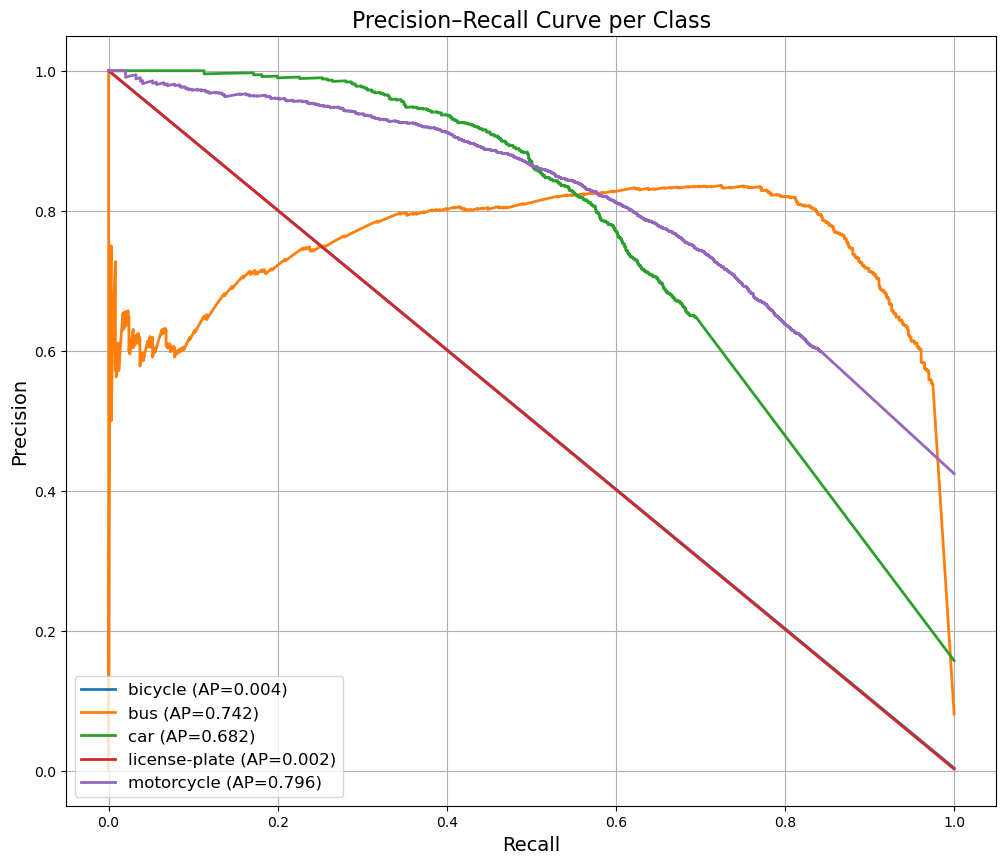


Average Precision (AP) per class:
bicycle: 0.0039
bus: 0.7416
car: 0.6817
license-plate: 0.0024
motorcycle: 0.7961


In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]
NUM_CLASSES = len(CLASS_NAMES)

# ------------------------------------------
# Convert y_true/y_pred into one-vs-all matrix
# ------------------------------------------
y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

plt.figure(figsize=(12, 10))

ap_per_class = {}

for cls in range(NUM_CLASSES):

    # ------------------------------------------
    # Create binary GT vector for this class
    # ------------------------------------------
    y_true_binary = (y_true_arr == cls).astype(int)

    # Scores for this class: length must match y_pred
    # If no score recorded for this class, fill zeros
    if len(scores_by_class[cls]) > 0:
        # Expand scores to full length: assign score only where prediction class = cls
        scores_full = np.zeros_like(y_pred_arr, dtype=float)
        idx = np.where(y_pred_arr == cls)[0]

        # fill scores
        for k, score in zip(idx, scores_by_class[cls]):
            scores_full[k] = score
    else:
        # No predictions for this class
        scores_full = np.zeros_like(y_pred_arr, dtype=float)

    # ------------------------------------------
    # Skip classes with no GT
    # ------------------------------------------
    if y_true_binary.sum() == 0:
        print(f"No GT samples for class {CLASS_NAMES[cls]}, skipping.")
        continue

    # ------------------------------------------
    # PR Curve
    # ------------------------------------------
    precision, recall, thresholds = precision_recall_curve(
        y_true_binary, scores_full
    )

    ap = average_precision_score(y_true_binary, scores_full)
    ap_per_class[CLASS_NAMES[cls]] = ap

    plt.plot(recall, precision, label=f"{CLASS_NAMES[cls]} (AP={ap:.3f})", linewidth=2)


plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision–Recall Curve per Class", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.show()

print("\nAverage Precision (AP) per class:")
for cls, ap in ap_per_class.items():
    print(f"{cls}: {ap:.4f}")

#### Visualize few predictions from test dataset with confidence scores

In [ ]:
# Load best model for inference (only once)
import torch
import cv2
import matplotlib.pyplot as plt

# Load best trained model
model.load_state_dict(torch.load("detr_vehicle_model.pt"))
model.to(device)
model.eval()

CLASS_NAMES = ["bicycle", "bus", "car", "license-plate", "motorcycle"]

In [ ]:
# Function to visualize predictions on a single image
def visualize_prediction_with_class_counts(model, image_path, device, conf_thresh=0.5):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    img_tensor = torch.tensor(image / 255., dtype=torch.float32).permute(2,0,1).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    boxes  = output["boxes"].cpu().numpy()
    labels = output["labels"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    plt.figure(figsize=(10,8))
    plt.imshow(image)
    plt.axis("off")

    # Initialize class-wise counter
    class_counts = {cls: 0 for cls in CLASS_NAMES}
    total_count = 0

    for box, label, score in zip(boxes, labels, scores):

        if score < conf_thresh:
            continue

        total_count += 1

        x1, y1, x2, y2 = box
        class_name = CLASS_NAMES[label - 1]

        # Update class counter
        class_counts[class_name] += 1

        # Draw box
        rect = plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            edgecolor="red",
            linewidth=2
        )
        plt.gca().add_patch(rect)

        # Add label
        plt.text(
            x1,
            y1 - 5,
            f"{class_name} {score:.2f}",
            color="yellow",
            fontsize=11,
            backgroundcolor="black"
        )

    #  Show total detections on image
    plt.title(f"Detected Vehicles: {total_count}")
    plt.show()

    # Print class-wise count neatly
    print("\n------ Vehicle Count by Class ------")
    for cls, cnt in class_counts.items():
        print(f"{cls:15} : {cnt}")
    print("------------------------------------\n")

    # Also return the dictionary (useful for Streamlit later)
    return class_counts, total_count


Showing predictions for: Pho-Hue-Tran-Khat-Chan_7h30-8-9-22_0036_jpg.rf.4770fa34c8db8274633fc8970fc548d9.jpg


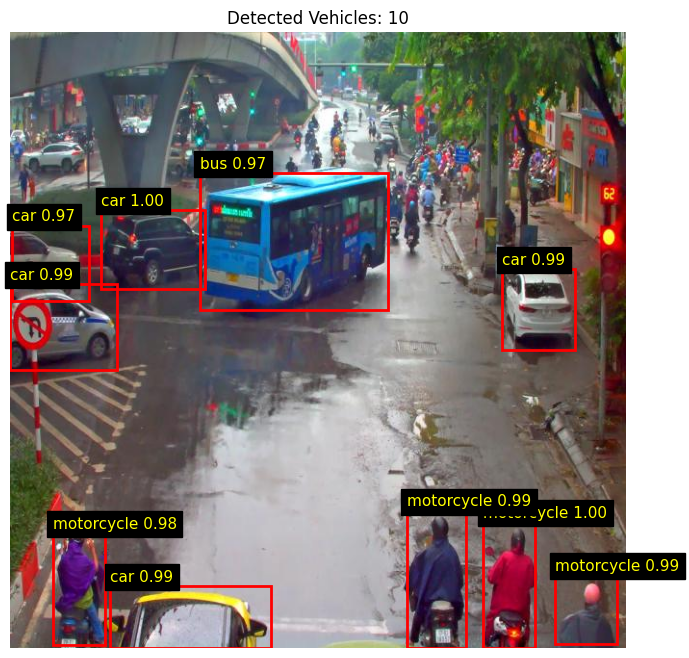


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 1
car             : 5
license-plate   : 0
motorcycle      : 4
------------------------------------


Showing predictions for: Le-Duan-Nguyen-Thai-Hoc_16h15-25-9-22_0019_jpg.rf.c548e90c2d54b2b3092e3a02fbd32375.jpg


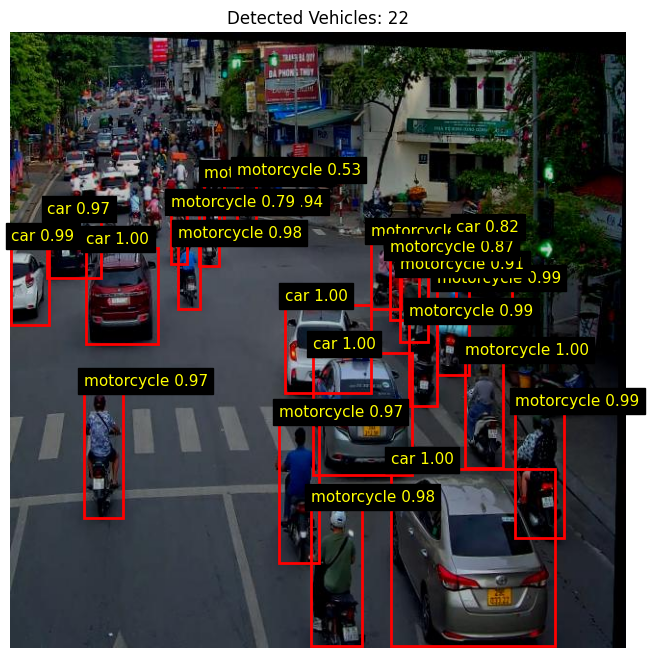


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 7
license-plate   : 0
motorcycle      : 15
------------------------------------


Showing predictions for: Hang-Bong-Hang-Trong_16h-30-25-9-22_0047_jpg.rf.8fe244001ea7208254f3464a2a6a90bb.jpg


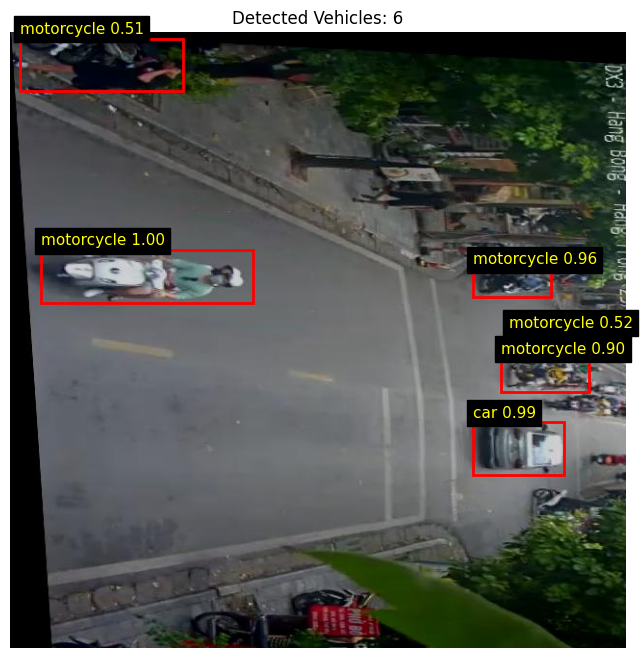


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 1
license-plate   : 0
motorcycle      : 5
------------------------------------


Showing predictions for: Lang-Ha-Thai-Ha-1-_16h-25-9-22_0052_jpg.rf.831e7266220b70b3dbfb717d64935f09.jpg


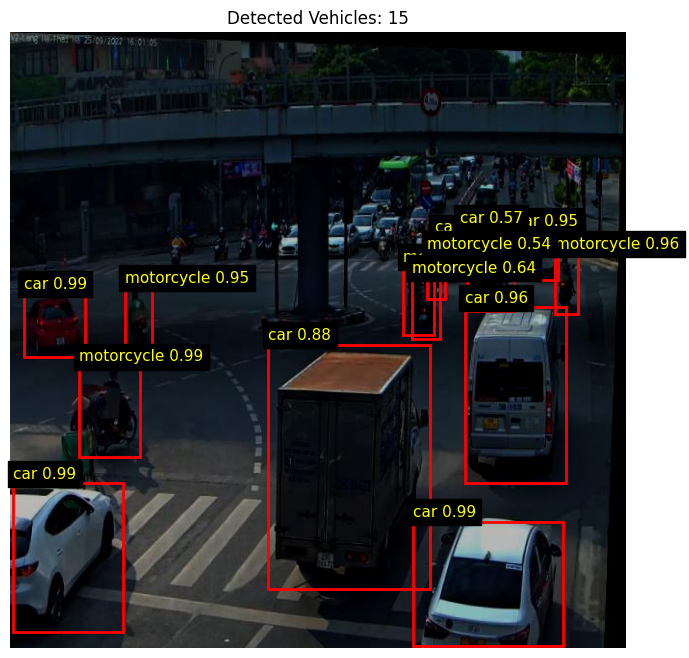


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 9
license-plate   : 0
motorcycle      : 6
------------------------------------


Showing predictions for: Le-Duan-Nguyen-Thai-Hoc_16h-15-9-22_0056_jpg.rf.32a2c45fafa06bbea9cda9f261e35e56.jpg


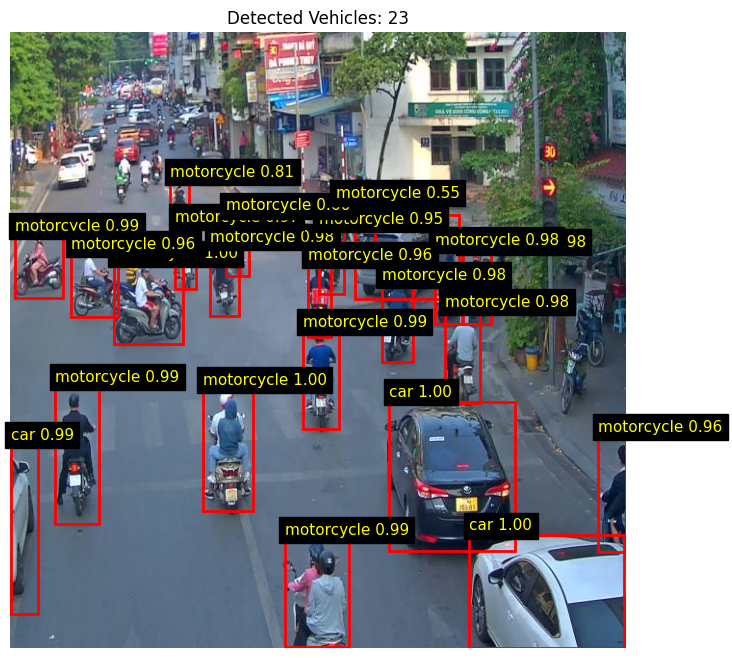


------ Vehicle Count by Class ------
bicycle         : 0
bus             : 0
car             : 4
license-plate   : 0
motorcycle      : 19
------------------------------------



In [ ]:
import random
import os

test_img_dir = "small_dataset/test/images"
test_images = os.listdir(test_img_dir)

# Pick 5 random test images
for img_name in random.sample(test_images, 5):

    img_path = os.path.join(test_img_dir, img_name)

    print(f"\nShowing predictions for: {img_name}")
    visualize_prediction_with_class_counts(model, img_path, device, conf_thresh=0.5)